# Loadind Dependencies

In [2]:
#Libraries Needed 
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from keras.models import Sequential
from keras.layers import LSTM, Dropout, RepeatVector, TimeDistributed, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model


In [3]:
np.random.seed(1)
tf.random.set_seed(1)
pd.options.mode.chained_assignment = None #remove warnings
sns.set(style = 'whitegrid', palette = 'muted')

print('Tensorflow version: ', tf.__version__)

Tensorflow version:  2.17.1


# Loading the Dataset

In [4]:
df = pd.read_csv('/kaggle/input/financial-stock-market-data/Stock_Market_Time_Series_Data.csv', parse_dates = ['Date'] )
df.head() 

,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-01-02,211.279999,211.279999,208.929993,209.589996,209.589996,98960000
1,1986-01-03,209.589996,210.880005,209.509995,210.880005,210.880005,105000000
2,1986-01-06,210.880005,210.979996,209.929993,210.649994,210.649994,99610000
3,1986-01-07,210.649994,213.800003,210.649994,213.800003,213.800003,153000000
4,1986-01-08,213.800003,214.570007,207.490005,207.970001,207.970001,180300000


In [5]:
#We are only interested in Date and Close columns. Lets drop the rest
df = df.drop(['Open', 'Adj Close', 'High', 'Volume', 'Low'], axis = 1) 
df.head() 

,Date,Close
0,1986-01-02,209.589996
1,1986-01-03,210.880005
2,1986-01-06,210.649994
3,1986-01-07,213.800003
4,1986-01-08,207.970001


In [6]:
# 📌 Add Technical Indicators

# Simple Moving Averages
df['SMA_20'] = df['Close'].rolling(window=20).mean()
df['SMA_50'] = df['Close'].rolling(window=50).mean()

# Exponential Moving Averages
df['EMA_20'] = df['Close'].ewm(span=20, adjust=False).mean()
df['EMA_50'] = df['Close'].ewm(span=50, adjust=False).mean()

# Relative Strength Index (RSI)
delta = df['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
df['RSI'] = 100 - (100 / (1 + rs))

# Bollinger Bands
df['Middle_Band'] = df['Close'].rolling(window=20).mean()
df['Std_Dev'] = df['Close'].rolling(window=20).std()
df['Upper_Band'] = df['Middle_Band'] + (2 * df['Std_Dev'])
df['Lower_Band'] = df['Middle_Band'] - (2 * df['Std_Dev'])


/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)


In [7]:
df.shape #Lets check dataset shape

(8678, 11)

# Visualize Trend

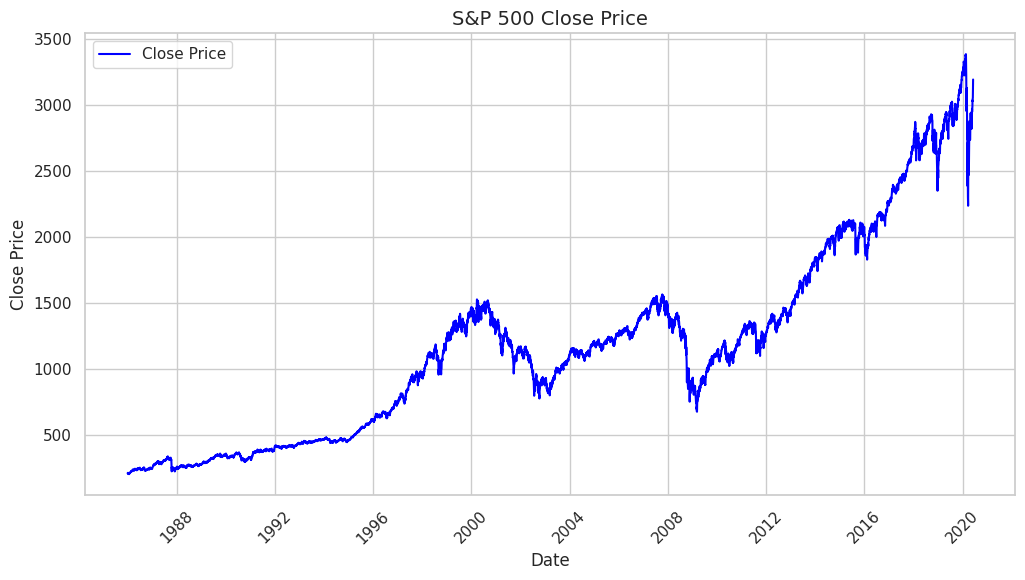

In [8]:
# Plot the closing prices to visualize the trend
def plot_close_prices():
    plt.figure(figsize=(12, 6))
    plt.plot(df['Date'], df['Close'], label='Close Price', color='blue')
    plt.title("S&P 500 Close Price", fontsize=14)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Close Price", fontsize=12)
    plt.grid(True)
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()

plot_close_prices()

# Data Preprocessing

In [9]:
# Data preprocessing
train_size = int(len(df) * 0.80)
train, test = df.iloc[:train_size], df.iloc[train_size:]
scaler = StandardScaler()
scaler.fit(train[['Close']])
train['Close'] = scaler.transform(train[['Close']])
test['Close'] = scaler.transform(test[['Close']])

# Data Splitting

In [10]:
# Create sequences for LSTM input
def create_sequence(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X.iloc[i:i+time_steps].values)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)


In [11]:
X_train, y_train = create_sequence(train[['Close']], train.Close, time_steps=30)
X_test, y_test = create_sequence(test[['Close']], test.Close, time_steps=30)

# Building the LSTM

In [12]:
# Build LSTM Autoencoder model
def LSTM_Autoencoder(timesteps, n_features):
    model = Sequential()
    model.add(LSTM(128, input_shape=(timesteps, n_features)))
    model.add(Dropout(0.2))
    model.add(RepeatVector(timesteps))
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(TimeDistributed(Dense(n_features)))
    model.compile(loss='mae', optimizer='adam')
    return model

In [13]:
timesteps = X_train.shape[1]
n_features = X_train.shape[2]
model = LSTM_Autoencoder(timesteps, n_features)
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 128)                 │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector (RepeatVector)         │ (None, 30, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 30, 128)             │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 30, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 30, 1)               │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 198,273 (774.50 KB)

 Trainable params: 198,273 (774.50 KB)

 Non-trainable params: 0 (0.00 B)

# Training the model

In [14]:
# Train the model
ES = EarlyStopping(monitor='val_loss', patience=10, mode='min')
MC = ModelCheckpoint('/kaggle/working/best_model.keras', monitor='val_loss', mode='min', save_best_only=True)
history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_split=0.2, callbacks=[ES, MC], shuffle=False)


Epoch 1/25
173/173 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.2756 - val_loss: 0.1248
Epoch 2/25
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1642 - val_loss: 0.0946
Epoch 3/25
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1548 - val_loss: 0.0788
Epoch 4/25
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1393 - val_loss: 0.0771
Epoch 5/25
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1432 - val_loss: 0.0813
Epoch 6/25
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1471 - val_loss: 0.0761
Epoch 7/25
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1450 - val_loss: 0.0873
Epoch 8/25
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1608 - val_loss: 0.0967
Epoch 9/25
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1525 - val_loss: 0.0829
Epoch 10/25
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1580 - val_loss: 0.1116
Epoch 11/25
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1667 - val_loss: 0.1053
Epoch 12/25
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/s

# Evaluation

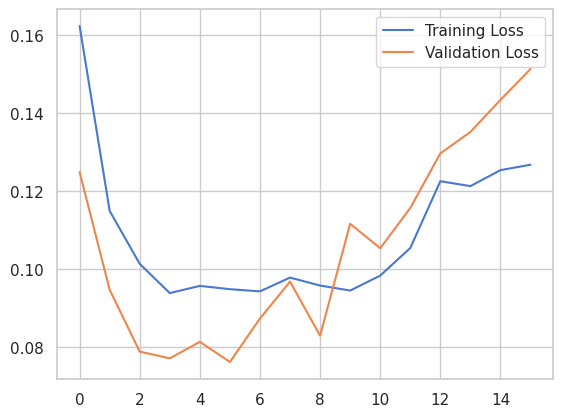

216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3325
 1/54 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

<ipython-input-15-c76a944f5aa0>:26: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_mae_loss, bins = 50, kde = True)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


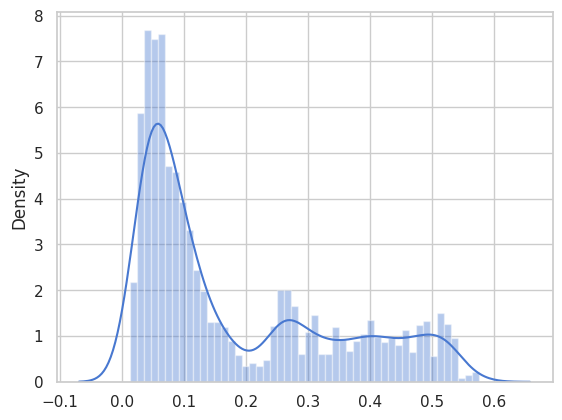

In [15]:
def trainloss_valloss():
    #Lets plot training and validation loss using matplotlib
    #The loss values are stored in history.history (dictionary)
    plt.plot(history.history['loss'], label = 'Training Loss') #Plotting training loss
    plt.plot(history.history['val_loss'], label = 'Validation Loss') #Plotting validation loss
    plt.legend() #Using labels as legend
    #If validation loss is lower than Training loss, it means the model is underfitting. 
    #If validation loss is higher than Training loss, it means the model is overfititng
    return plt.show()

trainloss_valloss() #Plot

#Load the best model observed as saved_model
saved_model = load_model('best_model.keras')


X_train_pred = saved_model.predict(X_train) #Model prediction on training data

#Save Mean Absolute Error to a pandas DataFrame in the Column 'Error'
train_mae_loss = pd.DataFrame(np.mean(np.abs(X_train_pred - X_train), axis = 1), columns = ['Error'])

#Evaluate the best model, saved_model on test data for total loss. 
saved_model.evaluate(X_test, y_test)

#Lets plot the distribution plot for MAE Loss Error using seaborn
sns.distplot(train_mae_loss, bins = 50, kde = True)

#Lets set a threshold for the MAE Loss. If error is larger, it will be predicted as an anomaly
threshold = 0.50 #This is the value that decides a data point is an anomaly or not. 

#Predict X_test
X_test_pred = saved_model.predict(X_test)

#Store MAE Loss for test data
test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis = 1)


# Anomaly Visulization

In [16]:
test_score_df = pd.DataFrame(test[timesteps:]) #We use the data that comes after time_steps in test data
test_score_df['loss'] = test_mae_loss #Create test_mae_loss column
test_score_df['threshold'] = threshold #Create threshold column
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold #Set anomaly as True if
test_score_df['Close'] = test[timesteps:].Close

#Lets see the newly created DataFrame
test_score_df.head()

#Show the last entries in the dataframe
test_score_df.tail()

def testloss_threshold():
    #Lets create an interactive chart with plotly to show data with anomalies
    fig = go.Figure() #Empty figure
    #Create lineplot with x-axis as values after timesteps and y-axis as loss values.
    fig.add_trace(go.Scatter(x = test[timesteps:].Date, y = test_score_df.loss,
                            mode = 'lines', name = 'Test Loss')) 
    
    #Create lineplot with x-axis as values after timesteps and y-axis as threshold.
    fig.add_trace(go.Scatter(x = test[timesteps:].Date, y = test_score_df.threshold,
                            mode = 'lines', name = 'Threshold')) 
    
    fig.update_layout(showlegend = True) #Add legend to plot
    
    return fig.show()

testloss_threshold() #Plot

#Lets create a DataFrame for all Anomalies. 
#We create a DataFrame only from True values in the anomaly column
anomalies = test_score_df[test_score_df.anomaly == True] 
anomalies.head()

def show_anomalies():
    # Lets create an interactive chart with plotly to show anomalies
    fig = go.Figure()  # Empty figure
    
    # Create lineplot with x-axis as test values after timesteps and y-axis as closing price.
    fig.add_trace(go.Scatter(x = test[timesteps:].Date, 
                            y = scaler.inverse_transform(test[timesteps:].Close.values.reshape(-1, 1)),  # Reshaped to 2D
                            mode = 'lines', name = 'Close Price')) 
    
    # Create lineplot with x-axis as anomaly dates. y-axis as anomaly price.
    # We use mode = markers to plot a scatter plot
    fig.add_trace(go.Scatter(x = anomalies.Date, 
                            y = scaler.inverse_transform(anomalies.Close.values.reshape(-1, 1)),  # Reshaped to 2D
                            mode = 'markers', name = 'Anomaly')) 
    
    fig.update_layout(showlegend = True)  # Add legend to plot
    fig.show()
    return plt.show()


In [17]:
print(anomalies.head())  # Check if anomalies are present


           Date     Close       SMA_20       SMA_50       EMA_20       EMA_50  \
7475 2015-08-26  2.481280  2055.047510  2079.429802  2031.062359  2066.706518   
7476 2015-08-27  2.591172  2048.999017  2077.174204  2026.928804  2063.606656   
7477 2015-08-28  2.593992  2043.250513  2074.526804  2023.304155  2060.675806   
7871 2017-03-23  3.426254  2370.079492  2329.182398  2360.411886  2331.432548   
7872 2017-03-24  3.421640  2368.911487  2330.555596  2358.846943  2331.924605   

            RSI  Middle_Band    Std_Dev   Upper_Band   Lower_Band      loss  \
7475  31.379990  2055.047510  74.249000  2203.545510  1906.549510  0.563809   
7476  39.429560  2048.999017  74.580822  2198.160662  1899.837373  0.563921   
7477  35.582294  2043.250513  74.562137  2192.374786  1894.126240  0.528217   
7871  32.573572  2370.079492  13.261051  2396.601593  2343.557391  0.510097   
7872  34.457751  2368.911487  14.487107  2397.885701  2339.937272  0.520965   

      threshold  anomaly  
7475       

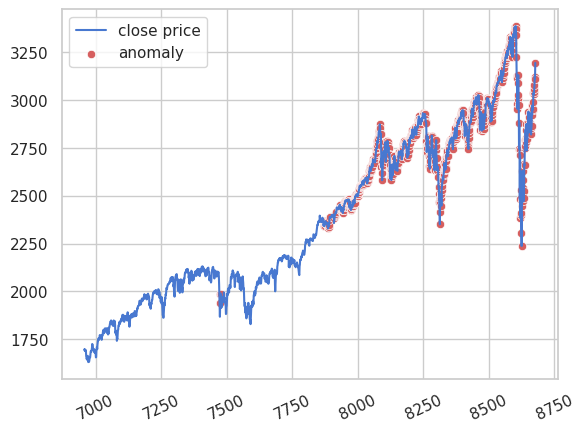

In [18]:
anomalies_close = anomalies[["Close"]].values.flatten()
anomalies_close = anomalies_close.reshape(-1, 1) # Reshape to a 2D array
anomalies_close = scaler.inverse_transform(anomalies_close)

time_steps=15
plt.plot(test[time_steps:].index, 
         scaler.inverse_transform(test[time_steps:][["Close"]]), 
         label='close price')

# convert it to a 1D array for the plot
anomalies_close = anomalies_close.flatten()
sns.scatterplot(x=anomalies.index, 
                y=anomalies_close, 
                color=sns.color_palette()[3], 
                label='anomaly'
               )

plt.xticks(rotation=25) 
plt.legend()
